# VIX Strategy backtest #

This script retrieves VIX spot index and VIX futures data from Quandl and attempts to generate trading signals based on historical prices. In particular, we pay close attention to the term structure of VIX front-month futures, which most of the time trade at a premium to the spot index. This market condition is also termed contango. Since the price of a future contract must converge with the spot price the closer we approach expiration, the persistence of contango in the VIX futures market means that investors can take advantage of it by establishing short positions in VIX futures. As long as the VIX index stays at a subdued level, futures contracts will gradually trade lower to converge with spot, in the process realizing a profit for the investor.

In this analysis, we have opted to trade in VIX ETFs instead of in futures so as to avoid the trouble of having to roll expiring contracts forward. The three ETFs that we employ are XIV (short VIX futures), UVXY (long VIX futures), and UPRO (long S&P 500), respectively. Only 1 of these 3 ETFs will be held at any given time. All trades are assumed to be transacted at market open price, based on closing prices of the various VIX indicators from the previous trading day.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd # pandas time series library
from datetime import datetime


In [3]:
def vixExpiration(year,month):
    """
    expiration date of a VX future
    
    """
    t = datetime(year,month,1)+pd.tseries.offsets.DateOffset(months=1)
    
    
    offset = pd.tseries.offsets.Week(weekday=4)
    if t.weekday()!=4:
        t_new = t+3*offset
    else:
        t_new = t+2*offset    
    
    t_exp = t_new-pd.tseries.offsets.DateOffset(days=30)
    return t_exp


def sharpe(pnl):
    return  np.sqrt(250)*pnl.mean()/pnl.std()


<b>Retrieve data from Quandl</b>

In [31]:
quandl_api_key = 'wxychbrgu7o7x3MRq4Hx'
start_date = '2011-10-04'

In [32]:
url = 'https://www.quandl.com/api/v3/datasets/CBOE/VIX.csv?api_key=' + quandl_api_key + '&start_date=' + start_date
vix = pd.read_csv(url, index_col=0, header = 0, parse_dates=True)

url = 'https://www.quandl.com/api/v3/datasets/CHRIS/CBOE_VX1.csv?api_key=' + quandl_api_key + '&start_date=' + start_date
UX1 = pd.read_csv(url, index_col=0, header = 0, parse_dates=True)

url = 'https://www.quandl.com/api/v3/datasets/CHRIS/CBOE_VX2.csv?api_key=' + quandl_api_key + '&start_date=' + start_date
UX2 = pd.read_csv(url, index_col=0, header = 0, parse_dates=True)

url = 'https://www.quandl.com/api/v3/datasets/EOD/XIV.csv?api_key=' + quandl_api_key + '&start_date=' + start_date
xiv = pd.read_csv(url, index_col=0, header = 0, parse_dates=True)

url = 'https://www.quandl.com/api/v3/datasets/EOD/UVXY.csv?api_key=' + quandl_api_key + '&start_date=' + start_date
uvxy = pd.read_csv(url, index_col=0, header = 0, parse_dates=True)

url = 'https://www.quandl.com/api/v3/datasets/EOD/UPRO.csv?api_key=' + quandl_api_key + '&start_date=' + start_date
upro = pd.read_csv(url, index_col=0, header = 0, parse_dates=True)

In [24]:
vix = vix['VIX Close']
UX1 = UX1.Settle
UX2 = UX2.Settle
xiv = xiv.Adj_Open
uvxy = uvxy.Adj_Open
upro = upro.Adj_Open

# conform index (dates) to futures (UX1), as futures data lag behind the rest
vix = vix.reindex(UX1.index)
xiv = xiv.reindex(UX1.index)
uvxy = uvxy.reindex(UX1.index)
upro = upro.reindex(UX1.index)

In [25]:
# combine data into 1 table
vixData = pd.concat([vix.rename('VIX'), UX1.rename('UX1'), UX2.rename('UX2')], axis=1)
vixData = vixData.sort_index()

etfData = pd.concat([xiv.rename('XIV'), uvxy.rename('UVXY'), upro.rename('UPRO')], axis=1)
etfData = etfData.sort_index()


<b> Enrich dataset </b>

In [26]:
# calculate 30 day VIX
vixData['expiry'] = 0
vixData['VIX_30day'] = 0

for i, d in enumerate(vixData.index):
    vixData.loc[vixData.index[i],'expiry'] = vixExpiration(d.year, d.month)
    v1 = (vixData.expiry[i] - vixData.index[i]).days * vixData.UX1[i]
    v2 = (30 - (vixData.expiry[i] - vixData.index[i]).days) * vixData.UX2[i]
    vixData.loc[vixData.index[i],'VIX_30day'] = (1/30) * (v1 + v2)

    
# VIX 250-day moving average
vixData['vix250ma'] = vixData['VIX'].rolling(window=250).mean()
vixData['vix250stdev'] = vixData['VIX'].rolling(window=250).std()
vixData['z_score'] = (vixData['VIX'] - vixData['vix250ma']) / vixData['vix250stdev']

# compute contango ratios
r_vix_ux1 = vixData.VIX / vixData.UX1
r_ux1_ux2 = vixData.UX1 / vixData.UX2
vixData['ratio_contango'] = (0.7 * r_vix_ux1 + 0.3 * r_ux1_ux2) - 1
vixData['vix_pct_chg'] = vixData.VIX.pct_change()


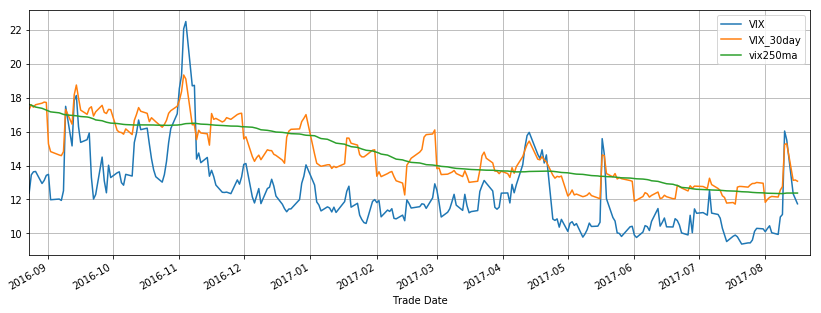

In [27]:
lookback = -252
figsize(14,5)
vixData[['VIX','VIX_30day', 'vix250ma']][lookback:].plot(grid=True)


## write backtest function ##

In [10]:
def vixEtfStrategy(etfPrice, vixData, contango_lBound=-0.05, contango_uBound=0.05):
    pos = pd.DataFrame(index = vixData.index) # initiate position dataframe
    pos['XIV'] = 0
    pos['UVXY'] = 0
    pos['UPRO'] = 0

    pos['XIV'][(vixData['ratio_contango'] < contango_lBound) | (vixData['vix_pct_chg'] <= -0.1)] = 1
    pos['UVXY'][((vixData['ratio_contango'] > contango_uBound) | (vixData['vix_pct_chg'] >= 0.1)) & (pos['XIV'] != 1)] = 1

    
    pos['UPRO'][(pos['UVXY'] == 0) & (pos['XIV'] == 0)] = 1
    print (" XIV {0} days, UVXY {1} days, UPRO {2} days out of {3} days".format(len(pos[pos.XIV>0]), len(pos[pos.UVXY>0]), len(pos[pos.UPRO>0]), len(pos)))
    
    R = etfPrice.pct_change()
    R = R.shift(-2) # shift return backward 2 days ---> act on T-1 signal, need T+1 price for return
    
    pnl = pd.DataFrame(index = pos.index) # initiate pnl dataframe
    pnl['XIV_BH'] = (R.XIV) # XIV buy and hold
    pnl['XIV'] = (R.XIV * pos.XIV)
    pnl['UVXY'] = (R.UVXY * pos.UVXY)
    pnl['UPRO'] = (R.UPRO * pos.UPRO)
    pnl['Strategy'] = pnl.XIV + pnl.UVXY + pnl.UPRO

    return pnl, pos, R

In [11]:
pnl, pos, R = vixEtfStrategy(etfData, vixData,-0.05,0.05)

 XIV 939 days, UVXY 103 days, UPRO 439 days out of 1481 days


* XIV_BH: XIV Buy & Hold
* XIV: XIV component of Strategy
* UVXY: UVXY component of Strategy
* UPRO: UPRO component of Strategy
* Strategy: XIV + UVXY + UPRO

Sharpe ratio: 
 XIV_BH      1.050600
XIV         0.746176
UVXY        0.353987
UPRO        1.741332
Strategy    1.162768
dtype: float64 

PnL: 
             XIV_BH  XIV  UVXY  UPRO  Strategy
Trade Date                                   
2017-08-18     NaN  NaN   NaN   NaN       NaN


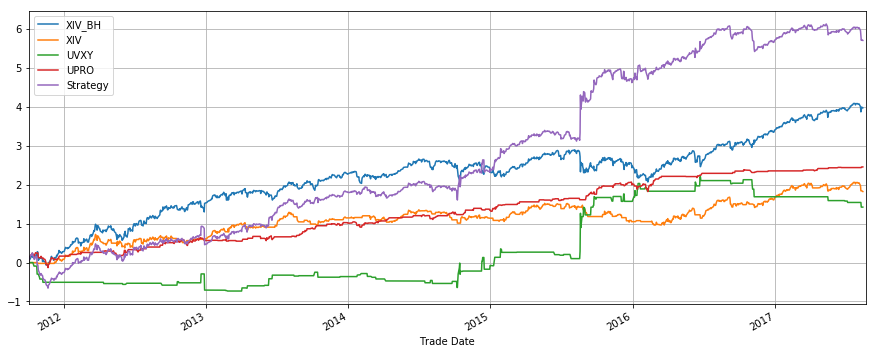

In [12]:
figsize(15,6)
#pnl_zoom = pnl[-1500:]  # select period for calculation
#pnl_zoom.cumsum().plot(grid=True)
pnl.cumsum().plot(grid=True)
#(1+pnl_zoom).cumprod().plot(grid=True)

print('Sharpe ratio: \n', sharpe(pnl), '\n')
print('PnL: \n', pnl.cumsum()[-3:-2])

## Optimize strategy parameters ##

In [13]:
lowerBound = arange(-0.15, 0.03, 0.01)
upperBound = arange(0.03, 0.10, 0.01)
SH = np.zeros((len(lowerBound), len(upperBound)))

 XIV 111 days, UVXY 154 days, UPRO 1216 days out of 1481 days
 XIV 111 days, UVXY 137 days, UPRO 1233 days out of 1481 days
 XIV 111 days, UVXY 131 days, UPRO 1239 days out of 1481 days
 XIV 111 days, UVXY 127 days, UPRO 1243 days out of 1481 days
 XIV 111 days, UVXY 126 days, UPRO 1244 days out of 1481 days
 XIV 111 days, UVXY 125 days, UPRO 1245 days out of 1481 days
 XIV 111 days, UVXY 122 days, UPRO 1248 days out of 1481 days
 XIV 111 days, UVXY 120 days, UPRO 1250 days out of 1481 days
 XIV 137 days, UVXY 154 days, UPRO 1190 days out of 1481 days
 XIV 137 days, UVXY 137 days, UPRO 1207 days out of 1481 days
 XIV 137 days, UVXY 131 days, UPRO 1213 days out of 1481 days
 XIV 137 days, UVXY 127 days, UPRO 1217 days out of 1481 days
 XIV 137 days, UVXY 126 days, UPRO 1218 days out of 1481 days
 XIV 137 days, UVXY 125 days, UPRO 1219 days out of 1481 days
 XIV 137 days, UVXY 122 days, UPRO 1222 days out of 1481 days
 XIV 137 days, UVXY 120 days, UPRO 1224 days out of 1481 days
 XIV 182

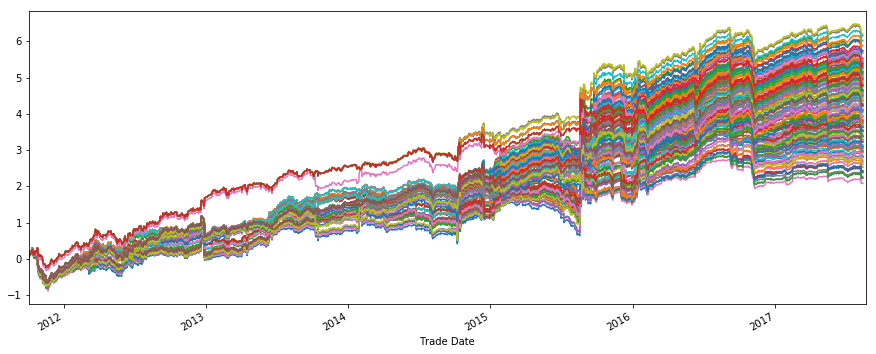

In [14]:
for i, lBound in enumerate(lowerBound):
    for j, uBound in enumerate(upperBound):
        pnl, pos, R = vixEtfStrategy(etfData, vixData, lBound, uBound)
        SH[i,j] = sharpe(pnl.Strategy)
        pnl.Strategy.cumsum().plot()

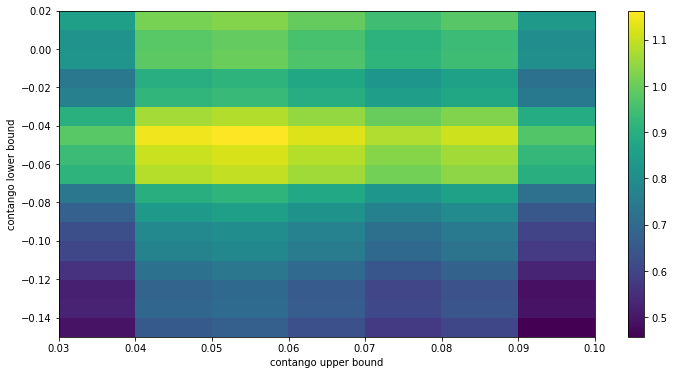

In [15]:
figsize(12,6)
pcolor(upperBound, lowerBound, SH)
xlabel('contango upper bound');
ylabel('contango lower bound')
colorbar();

